In [1]:
!kaggle datasets download -d marqui"s03/bdd100k"

Dataset URL: https://www.kaggle.com/datasets/marquis03/bdd100k
License(s): apache-2.0
100% 5.38G/5.38G [04:52<00:00, 21.0MB/s]
100% 5.38G/5.38G [04:52<00:00, 19.8MB/s]


In [2]:
import zipfile
# Replace 'path/to/your/zipfile.zip' with the actual path to your ZIP file
with zipfile.ZipFile('/content/bdd100k.zip', 'r') as zip_ref:
    zip_ref.extractall()


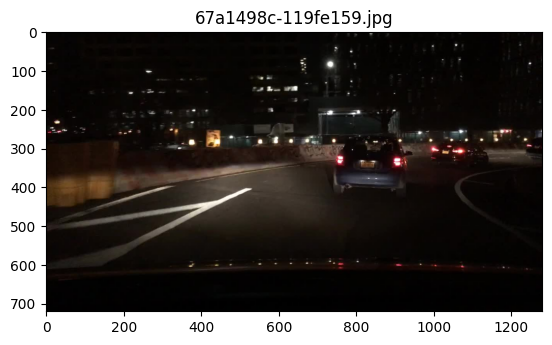

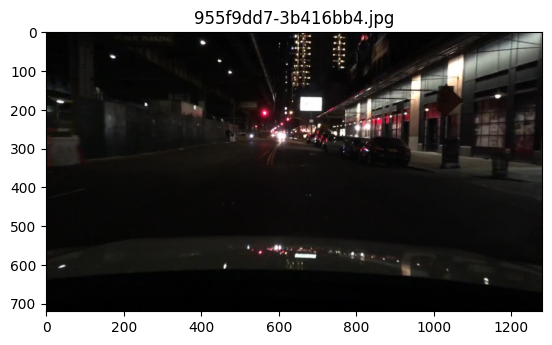

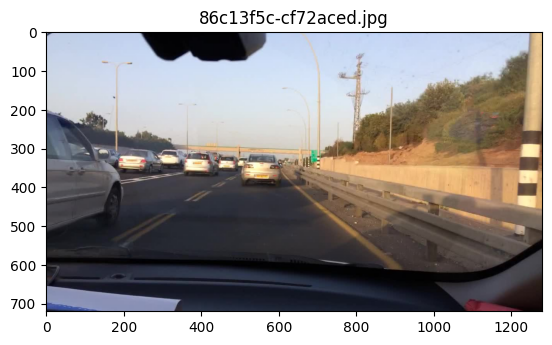

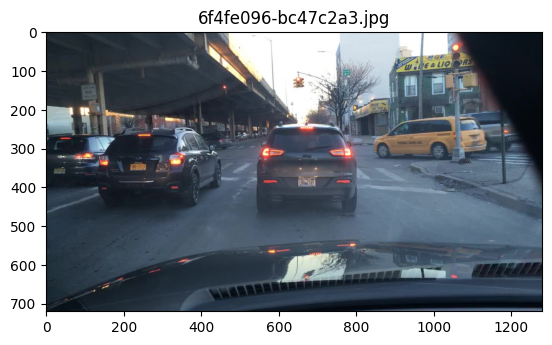

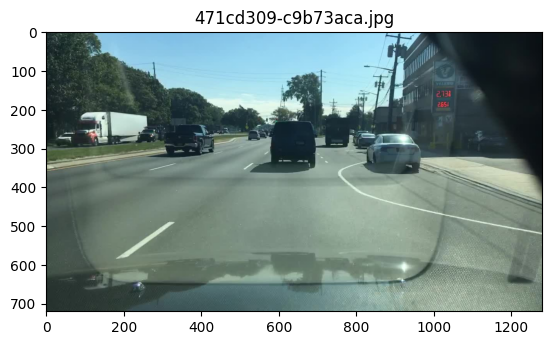

In [3]:
import os
import matplotlib.pyplot as plt

# Replace 'path/to/your/images/directory' with the actual path to your images directory
image_dir = '/content/train/images'

# Get a list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]  # Assuming JPG format

# Display the first few images
for i in range(5):  # Display the first 5 images
    image_path = os.path.join(image_dir, image_files[i])
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


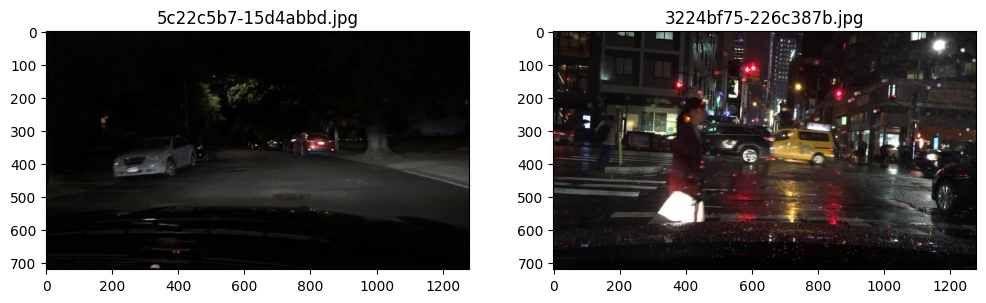

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


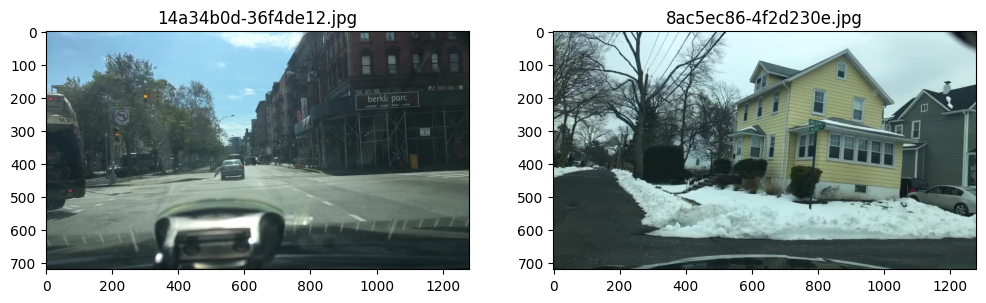

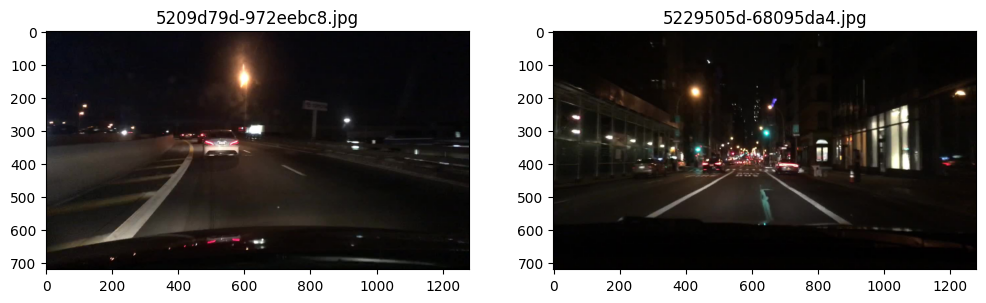

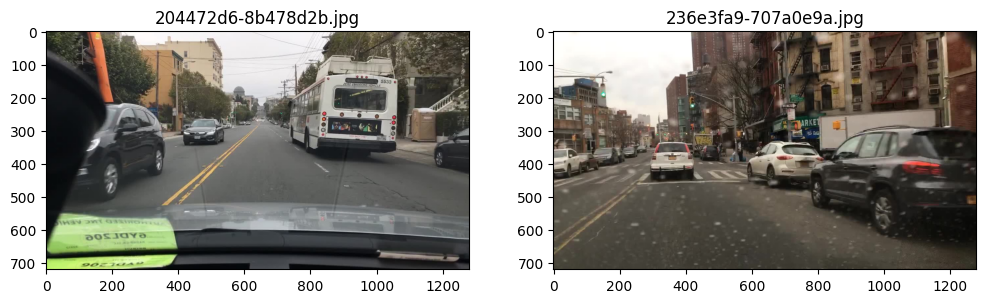

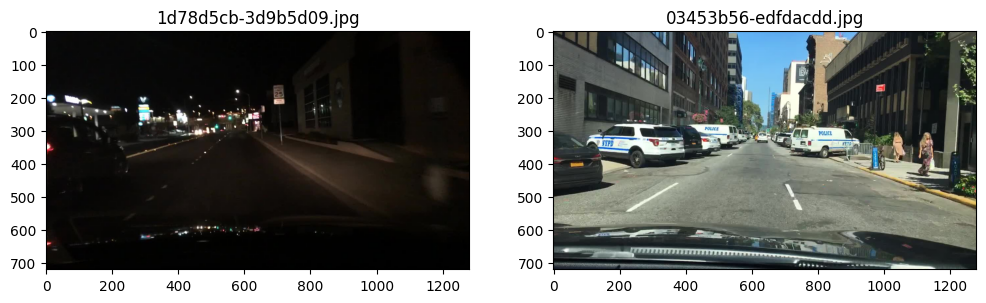

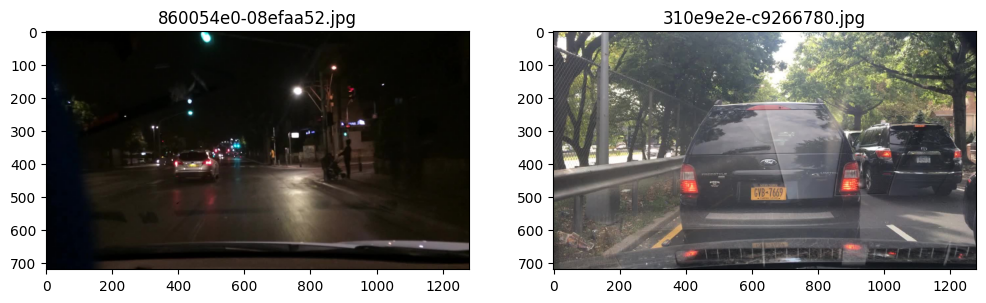

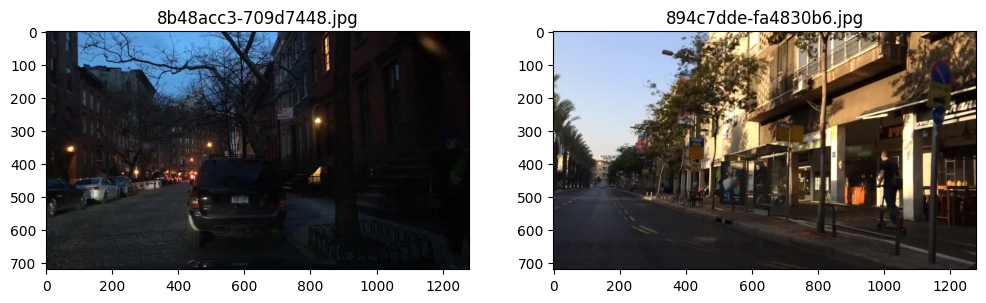

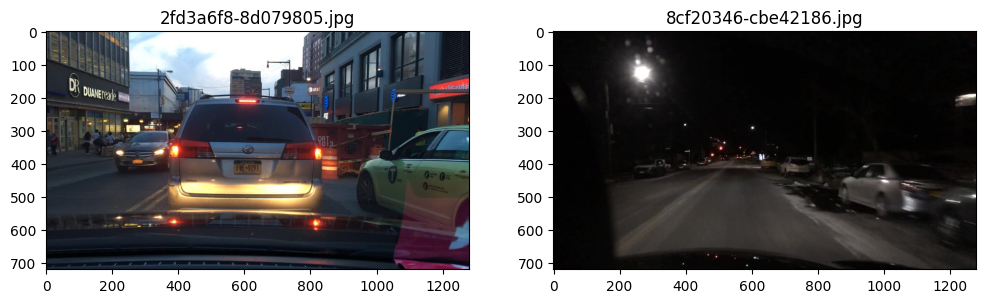

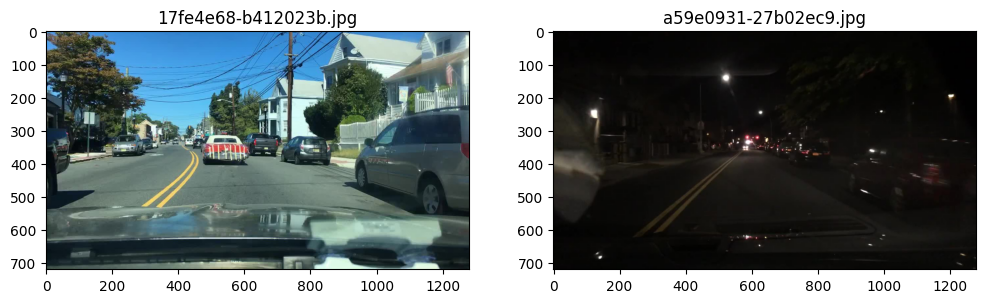

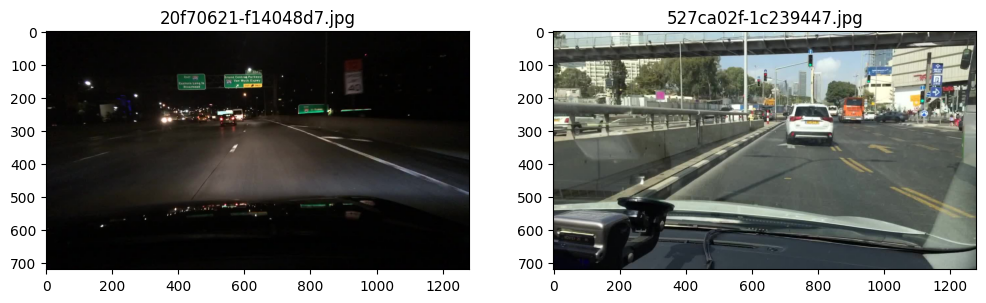

                 Image 1                            Latent Representation 1  \
0  5c22c5b7-15d4abbd.jpg  [[0.6103236, 0.65566283, -1.0446075, -0.046472...   
1  14a34b0d-36f4de12.jpg  [[0.6155119, 0.657022, -1.0555296, -0.04020765...   
2  5209d79d-972eebc8.jpg  [[0.61315215, 0.64635324, -1.034529, -0.042587...   
3  204472d6-8b478d2b.jpg  [[0.61487514, 0.6321852, -1.0948291, -0.022545...   
4  1d78d5cb-3d9b5d09.jpg  [[0.61378753, 0.6549311, -1.0406338, -0.044831...   

                 Image 2                            Latent Representation 2  
0  3224bf75-226c387b.jpg  [[0.61487544, 0.650114, -1.0391968, -0.0455099...  
1  8ac5ec86-4f2d230e.jpg  [[0.6230235, 0.66719973, -1.0769349, -0.037762...  
2  5229505d-68095da4.jpg  [[0.6187889, 0.63989705, -1.0357937, -0.044399...  
3  236e3fa9-707a0e9a.jpg  [[0.6275884, 0.6397608, -1.0514562, -0.0363867...  
4  03453b56-edfdacdd.jpg  [[0.62570757, 0.64444566, -1.0443523, -0.03846...  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import base64
import torch
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
import torchvision.transforms as transforms  # For image augmentation

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CSV data
df = pd.read_csv('/content/image_pairs.csv')

# Image directory
image_dir = '/content/train/images'

# Load a pre-trained Vision Transformer model (using ViT Base)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode

# Define image augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

def load_and_preprocess_image(image_path):
    """Load and preprocess the image for the model."""
    with Image.open(image_path) as img:
        img = augmentation(img)  # Apply augmentation
        img = feature_extractor(images=img, return_tensors="pt").to(device)  # Preprocess for ViT and move to GPU
    return img

# List to store latent representations
latent_representations = []

# Display only the first N pairs and extract latent representations
num_pairs_to_display = 10
for index, row in df.iterrows():
    if index >= num_pairs_to_display:
        break  # Stop iterating after displaying the desired number of pairs

    image_1 = row['Image 1']
    image_2 = row['Image 2']

    # Check if images exist in the directory
    image_1_path = os.path.join(image_dir, image_1)
    image_2_path = os.path.join(image_dir, image_2)

    if os.path.exists(image_1_path) and os.path.exists(image_2_path):
        # Display the images
        img1 = plt.imread(image_1_path)
        img2 = plt.imread(image_2_path)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(image_1)

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(image_2)

        plt.show()

        # Load and preprocess images
        img1_tensor = load_and_preprocess_image(image_1_path)
        img2_tensor = load_and_preprocess_image(image_2_path)

        # Extract latent representations
        with torch.no_grad():  # Disable gradient calculation
            latent_rep_1 = model(**img1_tensor).last_hidden_state.flatten(start_dim=1).cpu().numpy()  # Extract representation for image 1
            latent_rep_2 = model(**img2_tensor).last_hidden_state.flatten(start_dim=1).cpu().numpy()  # Extract representation for image 2

        # Store the latent representations in a dictionary
        latent_representations.append({
            'Image 1': image_1,
            'Latent Representation 1': latent_rep_1,
            'Image 2': image_2,
            'Latent Representation 2': latent_rep_2,
        })

    else:
        print(f"Image paths not found: {image_1_path}, {image_2_path}")

# Convert the list of latent representations to a DataFrame for further analysis
latent_df = pd.DataFrame(latent_representations)

# Save to a CSV file
latent_df.to_csv('latent_representations_vit.csv', index=False)

# Display the DataFrame
print(latent_df.head())


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load latent representations from CSV file
latent_df = pd.read_csv('/content/latent_representations_vit.csv')

# Check the DataFrame content
print("Initial DataFrame:")
print(latent_df.head())

# Convert the DataFrame to a NumPy array with numeric types
latent_array = latent_df.apply(pd.to_numeric, errors='coerce').values

# Check for NaN values and handle them (if any)
if np.any(np.isnan(latent_array)):
    print("Warning: NaN values found in the array. Filling NaNs with zeros.")
    latent_array = np.nan_to_num(latent_array)

# Convert to PyTorch tensor
latent_tensor = torch.FloatTensor(latent_array).to(device)

# Define Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Use Sigmoid if your input data is normalized
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create DataLoader
batch_size = 32
dataset = TensorDataset(latent_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the autoencoder
input_dim = latent_tensor.size(1)
hidden_dim = 256  # You can adjust this size
autoencoder = Autoencoder(input_dim, hidden_dim).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for data in data_loader:
        # Get the input data
        img_input = data[0].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(img_input)
        loss = criterion(outputs, img_input)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get the embeddings
with torch.no_grad():
    embeddings = autoencoder.encoder(latent_tensor).cpu().numpy()

# Store the embeddings in a DataFrame
embedding_df = pd.DataFrame(embeddings, columns=[f'Embedding_{i}' for i in range(embeddings.shape[1])])

# Save to a CSV file
embedding_df.to_csv('latent_embeddings_autoencoder.csv', index=False)

# Display the DataFrame
print(embedding_df.head())

Initial DataFrame:
                 Image 1                            Latent Representation 1  \
0  5c22c5b7-15d4abbd.jpg  [[ 0.6103236   0.65566283 -1.0446075  ...  0.3...   
1  14a34b0d-36f4de12.jpg  [[ 0.6155119   0.657022   -1.0555296  ...  0.3...   
2  5209d79d-972eebc8.jpg  [[ 0.61315215  0.64635324 -1.034529   ...  0.3...   
3  204472d6-8b478d2b.jpg  [[ 0.61487514  0.6321852  -1.0948291  ...  0.4...   
4  1d78d5cb-3d9b5d09.jpg  [[ 0.61378753  0.6549311  -1.0406338  ...  0.3...   

                 Image 2                            Latent Representation 2  
0  3224bf75-226c387b.jpg  [[ 0.61487544  0.650114   -1.0391968  ...  0.3...  
1  8ac5ec86-4f2d230e.jpg  [[ 0.6230235   0.66719973 -1.0769349  ...  0.3...  
2  5229505d-68095da4.jpg  [[ 0.6187889   0.63989705 -1.0357937  ...  0.3...  
3  236e3fa9-707a0e9a.jpg  [[ 0.6275884   0.6397608  -1.0514562  ...  0.3...  
4  03453b56-edfdacdd.jpg  [[ 0.62570757  0.64444566 -1.0443523  ...  0.3...  
Epoch [1/20], Loss: 0.2470
Epoch [2/20

In [10]:
from google.colab import files  # Only needed if you're using Google Colab

# Download the CSV file (applicable in Jupyter Notebook and Google Colab)
files.download('latent_embeddings_autoencoder.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>